In [1]:
import pandas as pd
import numpy as np
import os
import re
import pyreadstat
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
def top2box(series, wgt, fam=False):
    if 6 in set(series):
        t2b = wgt[series.isin([5, 6])].sum()
    else:
        t2b = wgt[series.isin([4, 5])].sum()

    if fam:
        series_total = wgt[series != 1].sum()
    else:
        series_total = wgt[series.notna()].sum()

    return t2b, series_total

def hyp_test(freq_1, freq_2, tot_1, tot_2):
    #### Put the 'Truth' as #2 for the difference
    
    prop_1 = freq_1 / tot_1
    prop_2 = freq_2 / tot_2

    prop_diff = prop_2 - prop_1

    if (freq_1 == 0) & (freq_2 == 0):
        return [prop_1, prop_2, prop_diff, np.nan, "no"]

    prop_com = (freq_1 + freq_2) / (tot_1 + tot_2)

    alpha = 0.05

    z_score = np.abs((prop_1 - prop_2)) / \
              ((prop_com * (1 - prop_com) / tot_1) + (prop_com * (1 - prop_com) / tot_2)) ** 0.5

    p_val = (1 - st.norm.cdf(z_score)) * 2

    if p_val >= alpha:
        result = "no"
    else:
        result = "yes"

    return [prop_1, prop_2, prop_diff, p_val, result]

## Merge Data and Weights

- EDU1 is the OLD education buckets defined by GWP in 3117
- EDU2 is the NEW education buckets

In [5]:
wave = 7.0

# Read in weights
w_edu1 = pd.read_csv("NL_BG_std_edu/weighted.csv")
w_edu2 = pd.read_csv("NL_BG_alt_edu/weighted.csv")

# Read in Datafile
file = 'GoogleBrandgeist_Allwaves_NL_V1_IntUse_VariablePlan_CCS_Weight.sav'
d, meta = pyreadstat.read_sav(file)

d = d.loc[d.fv_wave == wave]

In [25]:
d['respondent_serial2'] = d.respondent_serial - 320700000
w_edu1['respondent_serial2'] = w_edu1.respondent_serial - 20000000
w_edu2['respondent_serial2'] = w_edu2.respondent_serial - 20000000

In [29]:
d = d.merge(w_edu1, on="respondent_serial2")
d = d.merge(w_edu2, on="respondent_serial2")

In [31]:
[i for i in d.columns if re.search("WEIGHT",i)]

['WEIGHT_MAIN_x', 'WEIGHT_MAIN_y']

In [33]:
d = d.rename(columns={'WEIGHT_MAIN_x': "weight_std", 'WEIGHT_MAIN_y': 'weight_alt'})

In [34]:
[i for i in d.columns if re.search("weight",i)]

['weight', 'weight_ccs', 'weight_std', 'weight_alt']

In [37]:
# Get country from datafile (another check that we're aren't incompetant)
if len(set(d.bd_country)) == 1:
    country = set(d.bd_country).pop()
    market = meta.variable_value_labels['bd_country'][country]
else: 
    print("WE HAVE FAILED.")
print(market)

long_table = pd.DataFrame({"Market": [],
                           "Wave": [],
                           "Metric": [],
                           "Freq_STD": [],
                           "Freq_ALT": [],
                           "Diff": [],
                           "P_Val": [],
                           "Sig": []
                          })

cols = [i for i in d.columns if re.search("qq",i)
                and not re.search("googleInitiatives|opinionOfGoogle|motv_bin", i)]

for col in cols:

    if 'familiarity' in col:
        fam = True
    else:
        fam = False

    try:
        # Get Top2box
        std_t2b, std_total = top2box(d[col], d['weight_std'], fam)
        alt_t2b, alt_total = top2box(d[col], d['weight_alt'], fam)
    except:
        print(col + " is not a top 2 boxable series! Oops!")

    # Hypothesis Test
    small_table = hyp_test(std_t2b, alt_t2b, std_total, alt_total)

    # Get label instead of column name
    ix = [i for i in range(len(meta.column_names)) if meta.column_names[i] == col]
    met = meta.column_labels[ix[0]]

    long_table = long_table.append({"Market": market,
                                    "Wave": wave,
                                    "Metric": met, 
                                    "Freq_STD": small_table[0], 
                                    "Freq_ALT": small_table[1], 
                                    "Diff": small_table[2], 
                                    "P_Val": small_table[3], 
                                    "Sig": small_table[4]}, ignore_index=True)

Netherlands


In [38]:
long_table.tail()

Market  Wave                                     Metric  Freq_STD  \
385  Netherlands   7.0      Impact of brand on society :    Apple  0.420077   
386  Netherlands   7.0   Impact of brand on society :    Facebook  0.215756   
387  Netherlands   7.0  Impact of brand on society :    Microsoft  0.449933   
388  Netherlands   7.0     Impact of brand on society :    Amazon  0.212965   
389  Netherlands   7.0    Impact of brand on society :    YouTube  0.378148   

     Freq_ALT      Diff     P_Val Sig  
385  0.412783 -0.007294  0.905614  no  
386  0.219736  0.003980  0.934077  no  
387  0.438945 -0.010988  0.846026  no  
388  0.194576 -0.018389  0.672002  no  
389  0.399130  0.020982  0.714550  no

In [39]:
# Check Sig Differences
df = long_table.loc[long_table.Sig == "yes"]
df.reindex(df.Diff.abs().sort_values(ascending=False).index)

Market  Wave                                             Metric  \
3    Netherlands   7.0                      Brand familiarity : Microsoft   
296  Netherlands   7.0  Company motivation attributes : Google - Motiv...   
1    Netherlands   7.0                          Brand familiarity : Apple   
4    Netherlands   7.0                         Brand familiarity : Amazon   
36   Netherlands   7.0          Brand pers attributes : Arrogant - Google   
30   Netherlands   7.0       Brand pers attributes : Threatening - Google   
118  Netherlands   7.0                       Company familiarity : Amazon   

     Freq_STD  Freq_ALT      Diff     P_Val  Sig  
3    0.514230  0.463063 -0.051166  0.005480  yes  
296  0.639141  0.596991 -0.042150  0.017955  yes  
1    0.425707  0.384396 -0.041311  0.023537  yes  
4    0.247216  0.209274 -0.037942  0.016019  yes  
36   0.262092  0.224439 -0.037653  0.016676  yes  
30   0.242795  0.209628 -0.033168  0.030586  yes  
118  0.197745  0.169068 -0.028677  0.048365  yes

Difference between Top2Box metrics (Alternate - Standard)


Text(0.5, 1.0, 'Difference between Top2Box metrics (Alternate - Standard)')

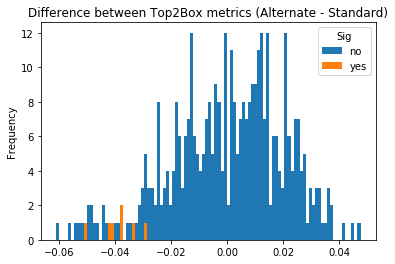

In [48]:
print("Difference between Top2Box metrics (Alternate - Standard)")
long_table.pivot(columns="Sig", values="Diff").plot.hist(bins=100)
plt.title("Difference between Top2Box metrics (Alternate - Standard)")

In [46]:
long_table.to_csv("BG_W7_Top2Box_FreqTables_" + market + ".csv", index = False)